In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path

In [4]:
path = Path('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/images'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/labels'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/images/Pig6_B_P_8_PEEP10_phase-00Low-slice144.png'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/images/Pig6_B_P_8_PEEP5_phase-01Low-slice321.png'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/images/Pig6_B_P_8_PEEP10_phase-01Low-slice093.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/labels/Pig6_B_P_8_PEEP5_phase-01_IRmmML-slice012.png'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/labels/Pig6_B_P_8_PEEP10_phase-00_IRmmML-slice263.png'),
 PosixPath('/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/labels/Pig6_B_P_8_PEEP10_phase-01_IRmmML-slice012.png')]

/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/images/Pig6_B_P_8_PEEP10_phase-00Low-slice144.png


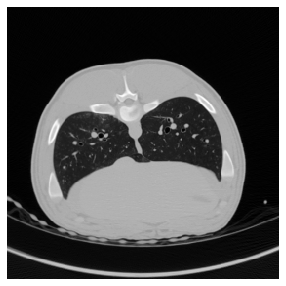

In [8]:
img_f = fnames[0]
img = open_image(img_f)
print(img_f)
img.show(figsize=(5,5))


In [9]:
img.data

tensor([[[0.0078, 0.0078, 0.0118,  ..., 0.0235, 0.0078, 0.0118],
         [0.0118, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0118],
         [0.0078, 0.0196, 0.0078,  ..., 0.0118, 0.0196, 0.0078],
         ...,
         [0.0667, 0.0588, 0.0588,  ..., 0.0510, 0.0706, 0.0667],
         [0.0431, 0.0706, 0.0745,  ..., 0.0510, 0.0510, 0.0627],
         [0.0745, 0.0745, 0.0471,  ..., 0.0863, 0.0667, 0.0706]],

        [[0.0078, 0.0078, 0.0118,  ..., 0.0235, 0.0078, 0.0118],
         [0.0118, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0118],
         [0.0078, 0.0196, 0.0078,  ..., 0.0118, 0.0196, 0.0078],
         ...,
         [0.0667, 0.0588, 0.0588,  ..., 0.0510, 0.0706, 0.0667],
         [0.0431, 0.0706, 0.0745,  ..., 0.0510, 0.0510, 0.0627],
         [0.0745, 0.0745, 0.0471,  ..., 0.0863, 0.0667, 0.0706]],

        [[0.0078, 0.0078, 0.0118,  ..., 0.0235, 0.0078, 0.0118],
         [0.0118, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0118],
         [0.0078, 0.0196, 0.0078,  ..., 0.0118, 0.0196, 0.

In [10]:
# def get_y_fn(x):
#     if "000" in str(x):
#         return path_lbl/str(x).replace("Low", "_IRmmML").split('/')[-1].replace("slice00", "slice")
        
#     else:
#         return path_lbl/str(x).replace("Low", "_IRmmML").split('/')[-1].replace("slice00", "slice").replace("slice0", "slice")
# get_y_fn = lambda x: path_lbl/str(x).replace(".nii.gz", "_m").split('/')[-1]
get_y_fn = lambda x: path_lbl/str(x).replace("Low", "_IRmmML").split('/')[-1]

/home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-copy/labels/Pig6_B_P_8_PEEP10_phase-00_IRmmML-slice144.png


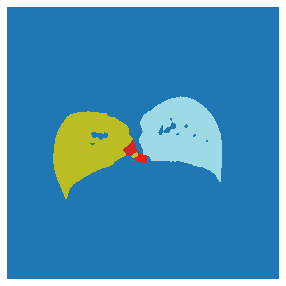

In [11]:
print(get_y_fn(img_f))
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([279, 279]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='<U1')

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5690MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(path/'valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

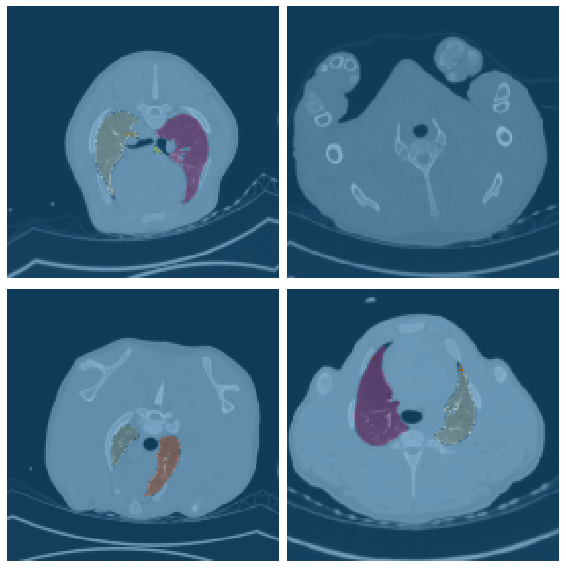

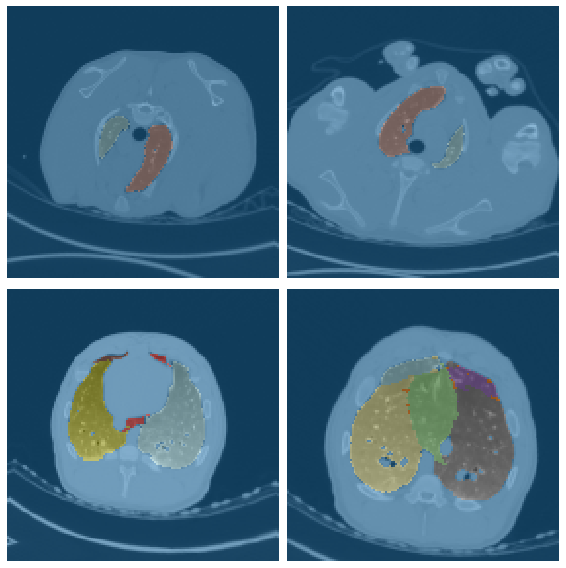

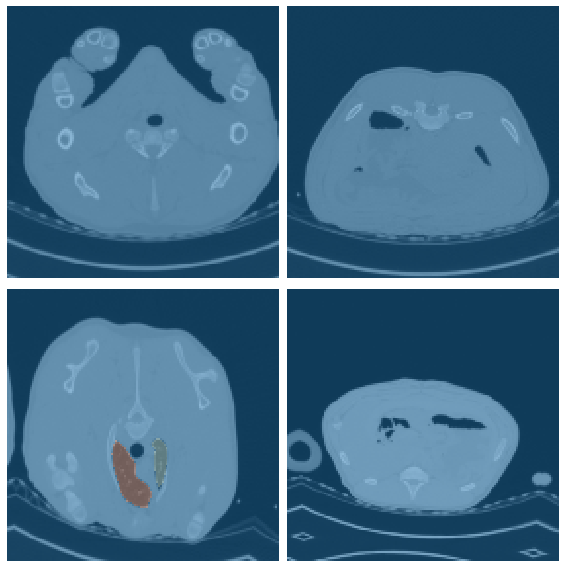

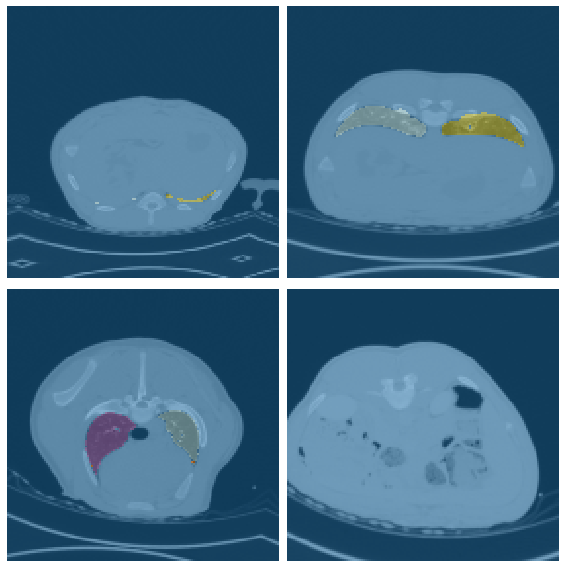

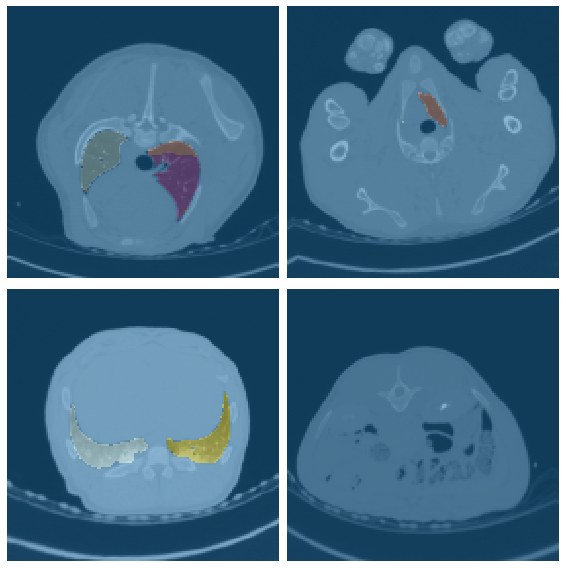

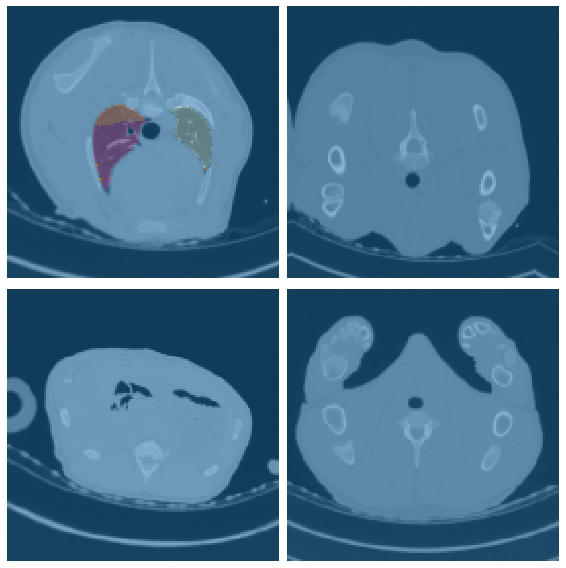

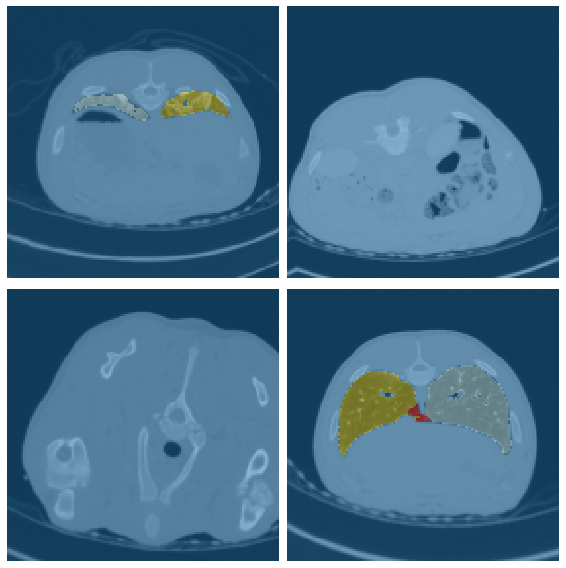

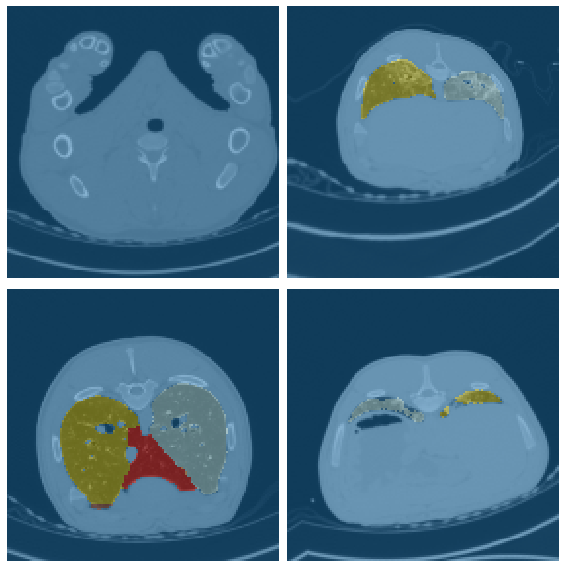

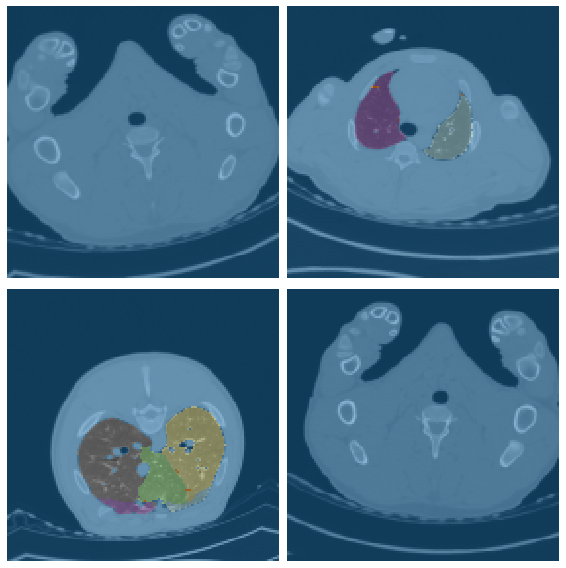

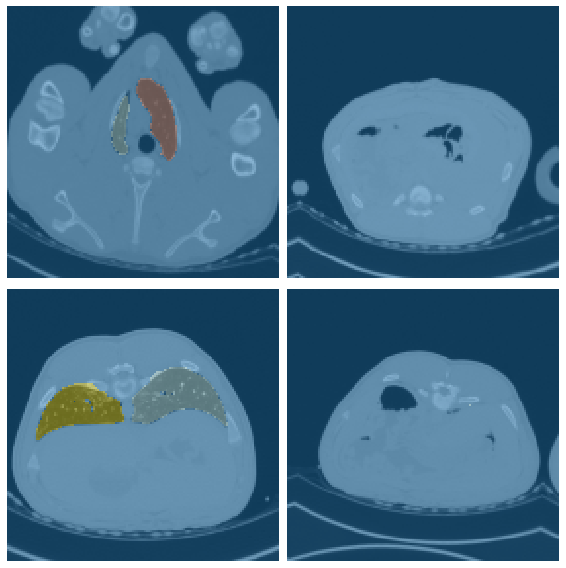

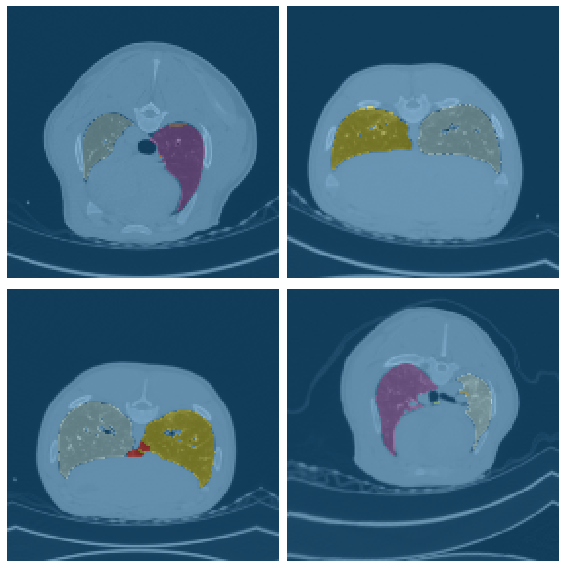

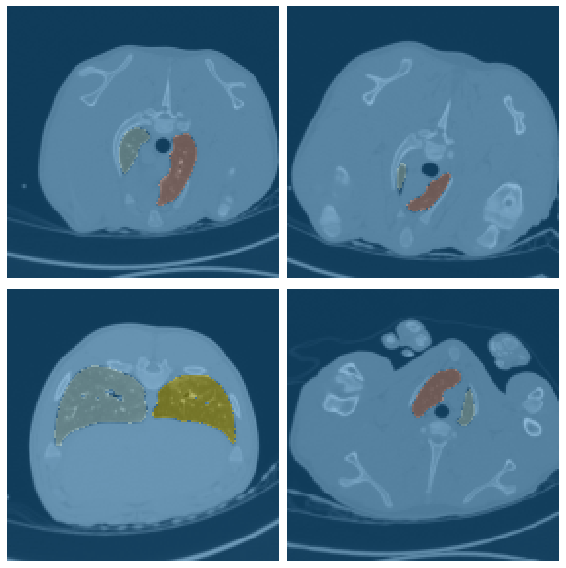

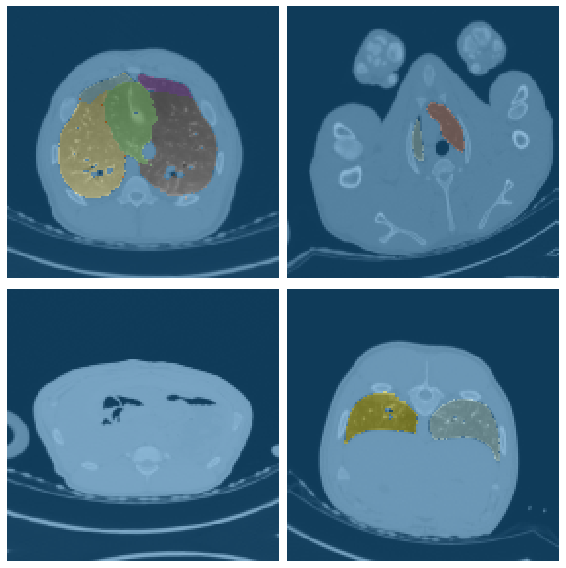

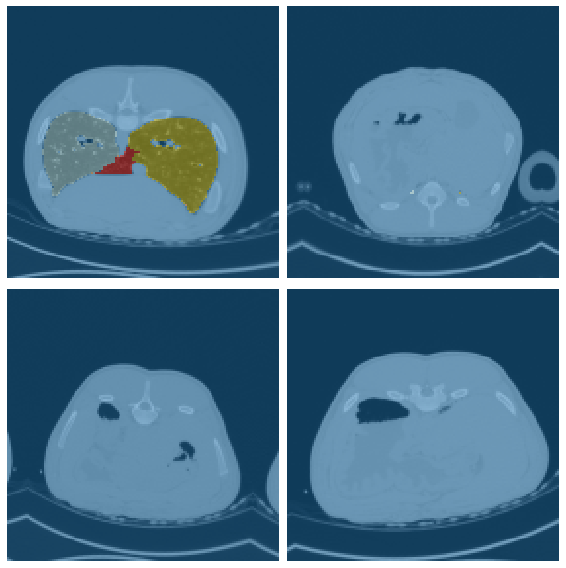

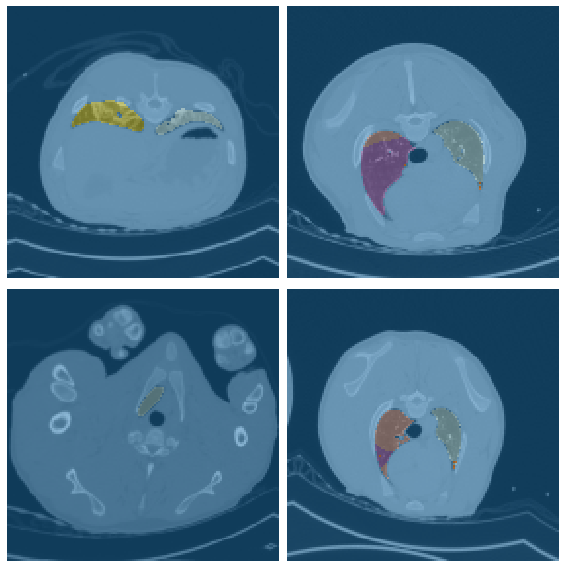

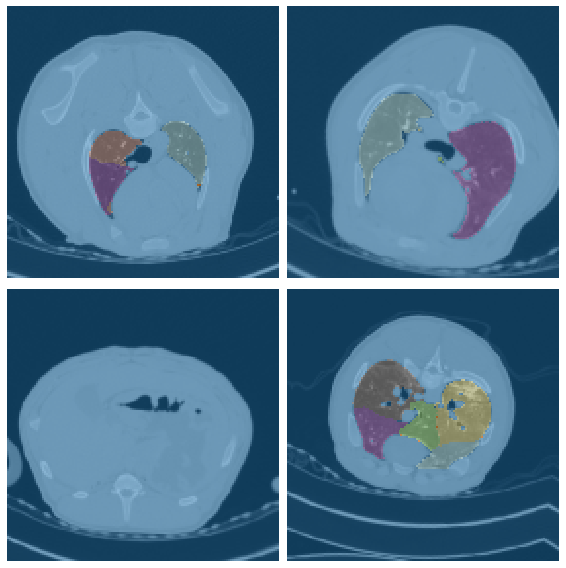

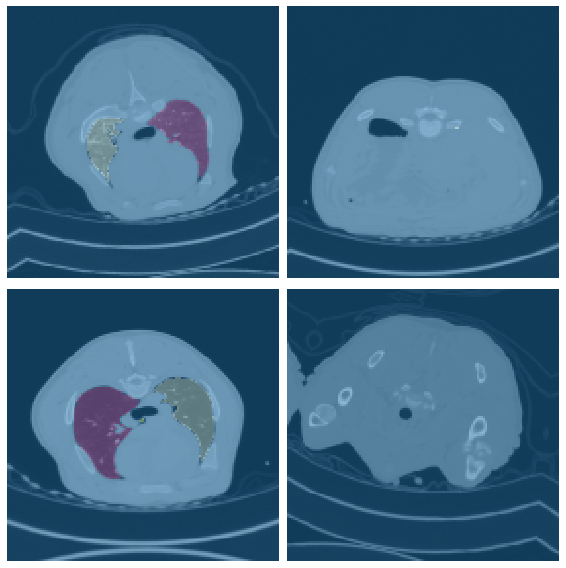

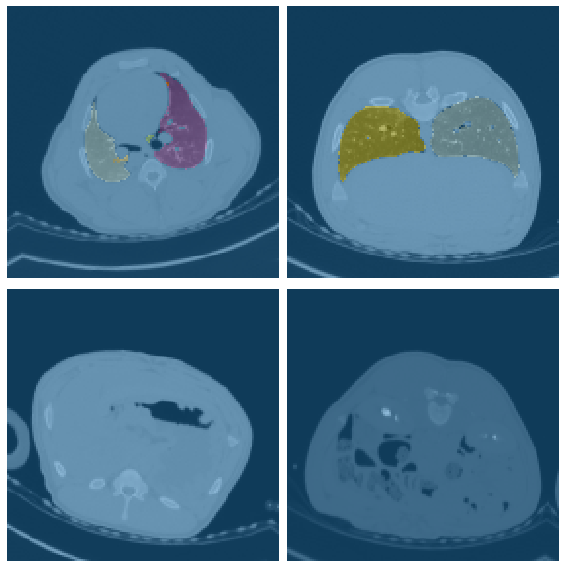

In [17]:
#Here I will show lots of images with masks to give an idea of the data
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()
data.show_batch()



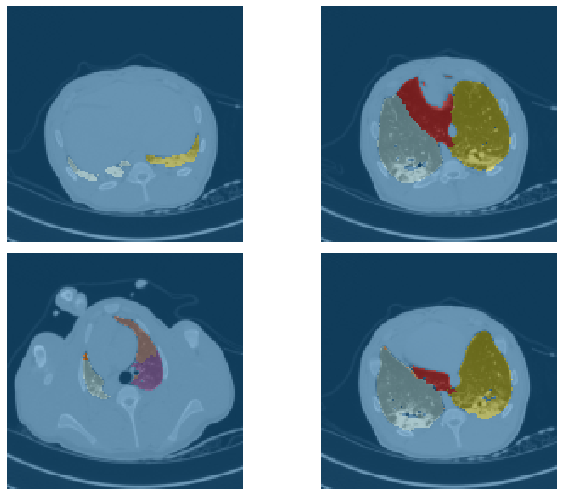

In [18]:
data.show_batch(figsize=(10,7), ds_type=DatasetType.Valid)

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=dice

In [21]:
wd=1e-2

In [22]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [23]:
learn.pred_batch()

tensor([[[[0.3042, 0.3305, 0.2789,  ..., 0.2462, 0.2540, 0.2384],
          [0.2829, 0.2514, 0.2433,  ..., 0.2354, 0.2769, 0.2719],
          [0.1734, 0.1437, 0.1510,  ..., 0.2158, 0.2658, 0.3284],
          ...,
          [0.0891, 0.1355, 0.1708,  ..., 0.1493, 0.1473, 0.2431],
          [0.0889, 0.0816, 0.1053,  ..., 0.1801, 0.2008, 0.2777],
          [0.3235, 0.3483, 0.2644,  ..., 0.3368, 0.3729, 0.3275]],

         [[0.1076, 0.1058, 0.0707,  ..., 0.1006, 0.1142, 0.1420],
          [0.0879, 0.0943, 0.0604,  ..., 0.0774, 0.0928, 0.1217],
          [0.1111, 0.1495, 0.1107,  ..., 0.0989, 0.0933, 0.1171],
          ...,
          [0.0848, 0.1202, 0.0898,  ..., 0.1532, 0.1511, 0.1552],
          [0.1023, 0.0754, 0.0633,  ..., 0.1857, 0.2097, 0.1660],
          [0.1497, 0.1140, 0.0498,  ..., 0.1529, 0.1364, 0.1538]],

         [[0.0851, 0.0978, 0.0749,  ..., 0.0547, 0.0578, 0.0941],
          [0.0733, 0.0919, 0.0570,  ..., 0.0566, 0.0572, 0.0918],
          [0.0786, 0.0838, 0.0779,  ..., 0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


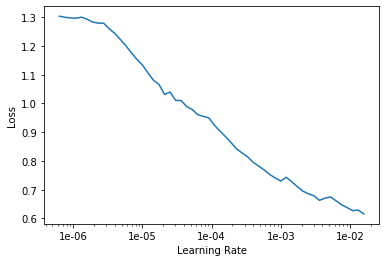

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=2e-5
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.171258,0.151647,nan,01:34
1,0.108931,0.113113,nan,01:31
2,370.736816,768.556763,nan,01:31


KeyboardInterrupt: 

In [27]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 70, 70]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 70, 70]         128        True      
______________________________________________________________________
ReLU                 [64, 70, 70]         0          False     
______________________________________________________________________
MaxPool2d            [64, 35, 35]         0          False     
______________________________________________________________________
Conv2d               [64, 35, 35]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 35, 35]         128        True      
______________________________________________________________________
ReLU                 [64, 35, 35]         0          False     
__________________________________________________

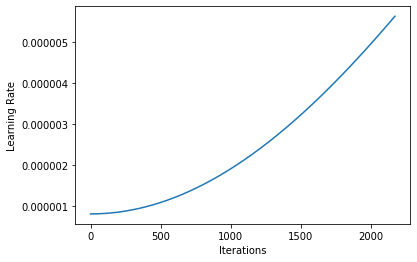

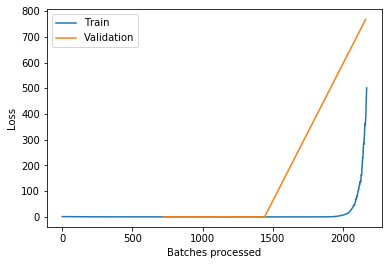

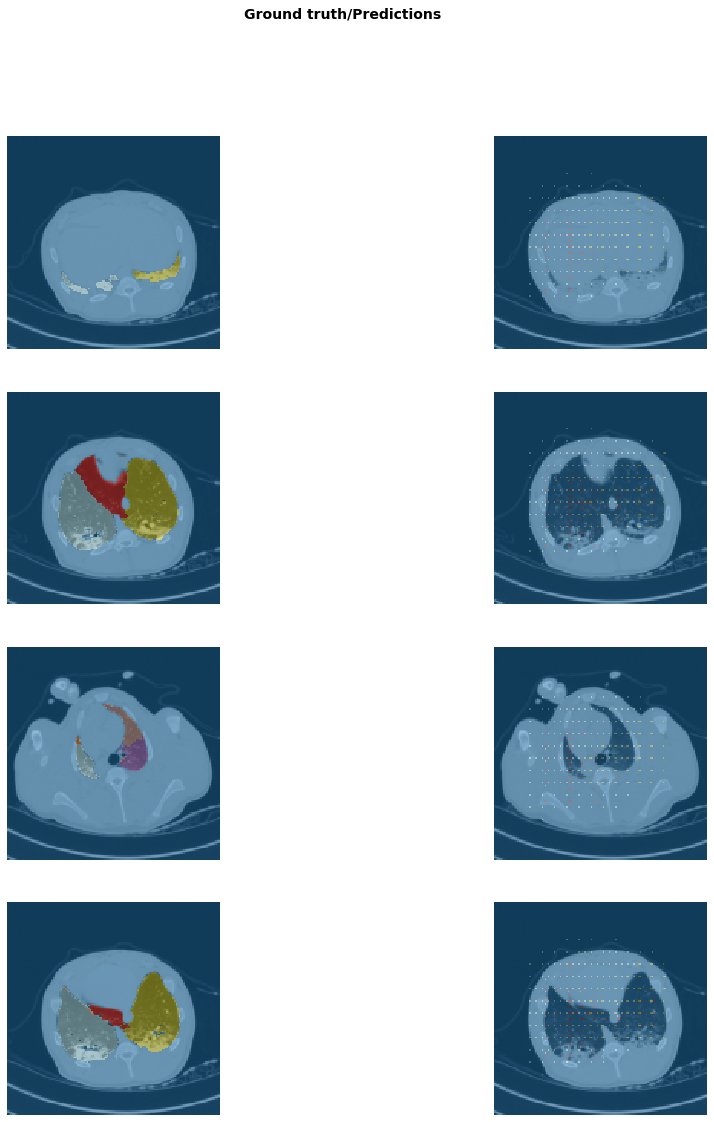

In [26]:
learn.recorder.plot_lr()
learn.recorder.plot_losses()

learn.show_results(figsize=(16,18))

In [ ]:
learn.save('multilobar-1')

In [67]:
learn.load('multilobar-1')

Learner(data=ImageDataBunch;

Train: LabelList (1021 items)
x: SegmentationItemList
Image (3, 148, 148),Image (3, 148, 148),Image (3, 148, 148),Image (3, 148, 148),Image (3, 148, 148)
y: SegmentationLabelList
ImageSegment (1, 148, 148),ImageSegment (1, 148, 148),ImageSegment (1, 148, 148),ImageSegment (1, 148, 148),ImageSegment (1, 148, 148)
Path: /home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-supine/images;

Valid: LabelList (578 items)
x: SegmentationItemList
Image (3, 148, 148),Image (3, 148, 148),Image (3, 148, 148),Image (3, 148, 148),Image (3, 148, 148)
y: SegmentationLabelList
ImageSegment (1, 148, 148),ImageSegment (1, 148, 148),ImageSegment (1, 148, 148),ImageSegment (1, 148, 148),ImageSegment (1, 148, 148)
Path: /home/jupyter/.fastai/data/multilobe-segmentation/fastai-data-supine/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): 

In [69]:
learn.unfreeze()
lrs = slice(lr/400,lr/4) 
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.063658,0.086009,nan,00:43
1,0.057802,0.087829,nan,00:43
2,0.058872,0.092212,nan,00:42
3,0.059166,0.093909,nan,00:43
4,0.058766,0.100429,nan,00:43
5,0.058268,0.103086,nan,00:43
6,0.071048,0.115743,nan,00:43
7,0.061659,0.120555,nan,00:43
8,0.067655,0.119664,nan,00:43
9,0.077733,0.140257,nan,00:43


In [ ]:
learn.save('multilobar-2')

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('multilobar-2')

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)